In [36]:
import pandas as pd

# Load data
df = pd.read_excel("third_mockup.xlsx")

# Move 'year' to the front
cols = df.columns.tolist()
if 'year' in cols:
    cols.insert(0, cols.pop(cols.index('year')))
df = df[cols]

# Display structure
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (67963, 189)
Columns: ['year', 'country', 'item', 'mean_cov_1', 'mean_cov_2', 'mean_cov_3', 'mean_cov_4', 'mean_cov_5', 'mean_cov_6', 'mean_cov_7', 'mean_cov_8', 'mean_cov_9', 'mean_cov_10', 'mean_cov_11', 'mean_cov_12', 'mean_cov_13', 'mean_cov_14', 'mean_cov_15', 'mean_cov_16', 'mean_cov_17', 'rain_1', 'rain_2', 'rain_3', 'rain_4', 'rain_5', 'rain_6', 'rain_7', 'rain_8', 'rain_9', 'rain_10', 'rain_11', 'rain_12', 'snow_1', 'snow_2', 'snow_3', 'snow_4', 'snow_5', 'snow_6', 'snow_7', 'snow_8', 'snow_9', 'snow_10', 'snow_11', 'snow_12', 'esoil_1', 'esoil_2', 'esoil_3', 'esoil_4', 'esoil_5', 'esoil_6', 'esoil_7', 'esoil_8', 'esoil_9', 'esoil_10', 'esoil_11', 'esoil_12', 'soilmoisture_0_10_1', 'soilmoisture_0_10_2', 'soilmoisture_0_10_3', 'soilmoisture_0_10_4', 'soilmoisture_0_10_5', 'soilmoisture_0_10_6', 'soilmoisture_0_10_7', 'soilmoisture_0_10_8', 'soilmoisture_0_10_9', 'soilmoisture_0_10_10', 'soilmoisture_0_10_11', 'soilmoisture_0_10_12', 'soilmoisture_10_40_1', 'soilmoi

In [37]:
# Convert year to integer format (e.g. 2010, 2011, ...)
df['year_raw'] = df['year'].astype(int)  # backup for clean export
# Optional sanity check
print("Years in dataset:", sorted(df['year'].unique()))

Years in dataset: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]


In [38]:
# Shift Yield by -1 per country/item
df['target'] = df.groupby(['country', 'item'])['yield'].shift(-1)

# Drop rows without target
df = df.dropna(subset=['target']).copy()

In [39]:
from sklearn.preprocessing import LabelEncoder

# Encode 'country' and 'item'
df['country_enc'] = LabelEncoder().fit_transform(df['country'])

df = pd.get_dummies(df, columns=['item'], prefix='item')


country_encoder = LabelEncoder()
df['country_id'] = country_encoder.fit_transform(df['country'])
num_countries = df['country_id'].nunique()

In [72]:
from sklearn.preprocessing import MinMaxScaler

# Features to exclude
exclude = ['Yield', 'target', 'country', 'year_raw', 'country_id']
one_hot_cols = [col for col in df.columns if col.startswith('item_')]
feature_cols = [col for col in df.columns if col not in exclude and col not in one_hot_cols]
feature_cols += one_hot_cols  # include one-hot columns explicitly

scaler = MinMaxScaler()
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')  # force numeric
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())  # fill NaNs

# add one-hot columns after fit transform because we don't want to scale one-hot columns (they are already 0/1)

# Create separate scaler for target
target_scaler = MinMaxScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['target']])

# Fill any remaining NaNs after scaling
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())

print(df[feature_cols].head())
results = df[feature_cols].copy()
results.to_csv("features.csv", index=False)


   year  mean_cov_1  mean_cov_2  mean_cov_3  mean_cov_4  mean_cov_5  \
0   0.0         1.0         0.0         0.0         0.0         0.0   
1   0.0         1.0         0.0         0.0         0.0         0.0   
2   0.0         1.0         0.0         0.0         0.0         0.0   
3   0.0         1.0         0.0         0.0         0.0         0.0   
4   0.0         1.0         0.0         0.0         0.0         0.0   

   mean_cov_6  mean_cov_7  mean_cov_8  mean_cov_9  ...  item_Tallowtree seeds  \
0         0.0         0.0         0.0         0.0  ...                    0.0   
1         0.0         0.0         0.0         0.0  ...                    0.0   
2         0.0         0.0         0.0         0.0  ...                    0.0   
3         0.0         0.0         0.0         0.0  ...                    0.0   
4         0.0         0.0         0.0         0.0  ...                    0.0   

   item_Tangerines, mandarins, clementines  item_Treenuts, Total  \
0                 

In [57]:
# all_years = sorted(df['year'].unique())
# cutoff_year = all_years[-2]  # second to last year

# train_df = df[df['year'] <= cutoff_year].copy().reset_index(drop=True)
# test_df = df[df['year'] > cutoff_year].copy().reset_index(drop=True)

# print(f"Train: years <= {cutoff_year}, Test: years > {cutoff_year}")
# print("Train size:", len(train_df), "Test size:", len(test_df))

from sklearn.model_selection import train_test_split

#Split the full cleaned DataFrame (after encoding + scaling + shift)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 49998
Test size: 12500


In [42]:
# Detect and drop constant features
zero_var_cols = train_df[feature_cols].loc[:, train_df[feature_cols].std() == 0].columns.tolist()
train_df = train_df.drop(columns=zero_var_cols)
test_df = test_df.drop(columns=zero_var_cols)
feature_cols = [col for col in feature_cols if col not in zero_var_cols]

In [58]:
import torch

# X_train = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
# # y_train = torch.tensor(train_df['target'].values, dtype=torch.float32).view(-1, 1)
# y_train = torch.tensor(train_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

# X_test = torch.tensor(test_df[feature_cols].values, dtype=torch.float32)
# # y_test = torch.tensor(test_df['target'].values, dtype=torch.float32).view(-1, 1)
# y_test = torch.tensor(test_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

# Rescale predictions back to actual yield units
X_train_num = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
X_train_country = torch.tensor(train_df['country_id'].values, dtype=torch.long)
y_train = torch.tensor(train_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

X_test_num = torch.tensor(test_df[feature_cols].values, dtype=torch.float32)
X_test_country = torch.tensor(test_df['country_id'].values, dtype=torch.long)
y_test = torch.tensor(test_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

In [59]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_train_num, X_train_country, y_train), batch_size=32, shuffle=True)

class MLPWithCountryEmbedding(nn.Module):
    def __init__(self, input_dim, num_countries, emb_dim=8):
        super().__init__()
        self.country_emb = nn.Embedding(num_countries, emb_dim)

        self.model = nn.Sequential(
            nn.Linear(input_dim + emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x_num, x_country):
        country_vec = self.country_emb(x_country)
        x = torch.cat([x_num, country_vec], dim=1)
        return self.model(x)
    

model = MLPWithCountryEmbedding(X_train_num.shape[1], num_countries, emb_dim=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.SmoothL1Loss()

for epoch in range(50):
    model.train()
    total_loss = 0.0
    for xb_num, xb_country, yb in train_loader:
        pred = model(xb_num, xb_country)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb_num.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

Epoch 1, Avg Loss: 0.0050
Epoch 2, Avg Loss: 0.0006
Epoch 3, Avg Loss: 0.0004
Epoch 4, Avg Loss: 0.0002
Epoch 5, Avg Loss: 0.0002
Epoch 6, Avg Loss: 0.0002
Epoch 7, Avg Loss: 0.0002
Epoch 8, Avg Loss: 0.0001
Epoch 9, Avg Loss: 0.0001
Epoch 10, Avg Loss: 0.0001
Epoch 11, Avg Loss: 0.0001
Epoch 12, Avg Loss: 0.0001
Epoch 13, Avg Loss: 0.0001
Epoch 14, Avg Loss: 0.0001
Epoch 15, Avg Loss: 0.0001
Epoch 16, Avg Loss: 0.0001
Epoch 17, Avg Loss: 0.0001
Epoch 18, Avg Loss: 0.0001
Epoch 19, Avg Loss: 0.0001
Epoch 20, Avg Loss: 0.0001
Epoch 21, Avg Loss: 0.0001
Epoch 22, Avg Loss: 0.0001
Epoch 23, Avg Loss: 0.0001
Epoch 24, Avg Loss: 0.0001
Epoch 25, Avg Loss: 0.0001
Epoch 26, Avg Loss: 0.0001
Epoch 27, Avg Loss: 0.0001
Epoch 28, Avg Loss: 0.0001
Epoch 29, Avg Loss: 0.0001
Epoch 30, Avg Loss: 0.0001
Epoch 31, Avg Loss: 0.0001
Epoch 32, Avg Loss: 0.0001
Epoch 33, Avg Loss: 0.0001
Epoch 34, Avg Loss: 0.0001
Epoch 35, Avg Loss: 0.0001
Epoch 36, Avg Loss: 0.0001
Epoch 37, Avg Loss: 0.0001
Epoch 38, 

In [60]:
from sklearn.metrics import mean_absolute_error

# Predict
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_num, X_test_country).numpy().flatten()  # predicted (scaled)
    y_true_test = y_test.numpy().flatten()                             # true (scaled)

# Inverse transform to original yield scale
y_pred_rescaled = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_true_rescaled = target_scaler.inverse_transform(y_true_test.reshape(-1, 1)).flatten()

# Calculate MAE
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
print(f"\n🧪 Test MAE: {mae:.2f}")


🧪 Test MAE: 2441.38


In [63]:
print("🔍 Prediction range:", y_pred_test.min(), "to", y_pred_test.max())
print("✅ True yield range:", y_true_test.min(), "to", y_true_test.max())

🔍 Prediction range: 0.004580779 to 0.6183776
✅ True yield range: 0.0 to 0.9194379


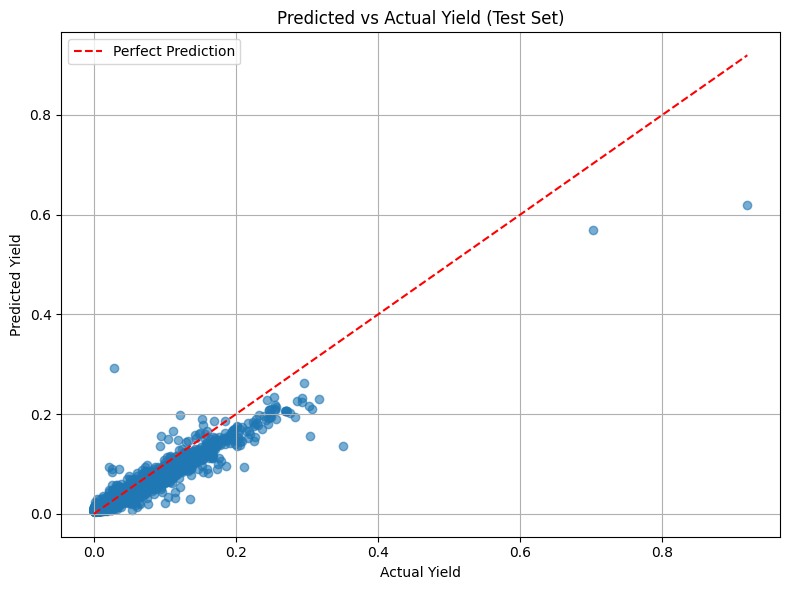

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true_test, y_pred_test, alpha=0.6)
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)

In [66]:
# 1. Recover the item name from one-hot columns
item_cols = [col for col in test_df.columns if col.startswith('item_')]
test_df['item'] = test_df[item_cols].idxmax(axis=1).str.replace('item_', '')

# 2. Restore predictions and ground truth
test_df['yield_true'] = y_true_rescaled
test_df['yield_pred'] = y_pred_rescaled

# 3. Select clean columns for display
results_table = test_df[['year_raw', 'country', 'item', 'yield_true', 'yield_pred']]
results_table = results_table.rename(columns={'year_raw': 'year'})

# 4. Preview the output
print(results_table.head(20))

    year              country  \
0   2018           Uzbekistan   
1   2019           Tajikistan   
2   2012              Ukraine   
3   2011           Montenegro   
4   2015           Madagascar   
5   2021   Russian Federation   
6   2012                 Mali   
7   2018             T√ºrkiye   
8   2015  Republic of Moldova   
9   2012                Spain   
10  2021   Russian Federation   
11  2016       C√¥te d'Ivoire   
12  2020               Latvia   
13  2016               Mexico   
14  2014            Lithuania   
15  2013                Egypt   
16  2016              Austria   
17  2011          Switzerland   
18  2015    Republic of Korea   
19  2019                Egypt   

                                                 item    yield_true  \
0                                              Apples  11408.400391   
1                                            Apricots   2789.000000   
2                                            Cherries   6548.399902   
3                     

In [67]:
results_table.to_csv("yield_predictions.csv", index=False)
print("✅ Results saved to 'yield_predictions.csv'")

✅ Results saved to 'yield_predictions.csv'


In [68]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Group and compute MAE per year
year_mae = test_df.groupby('year_raw').apply(
    lambda x: mean_absolute_error(x['yield_true'], x['yield_pred'])
).reset_index(name='mae')

/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_21569/3132263374.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_mae = test_df.groupby('year_raw').apply(


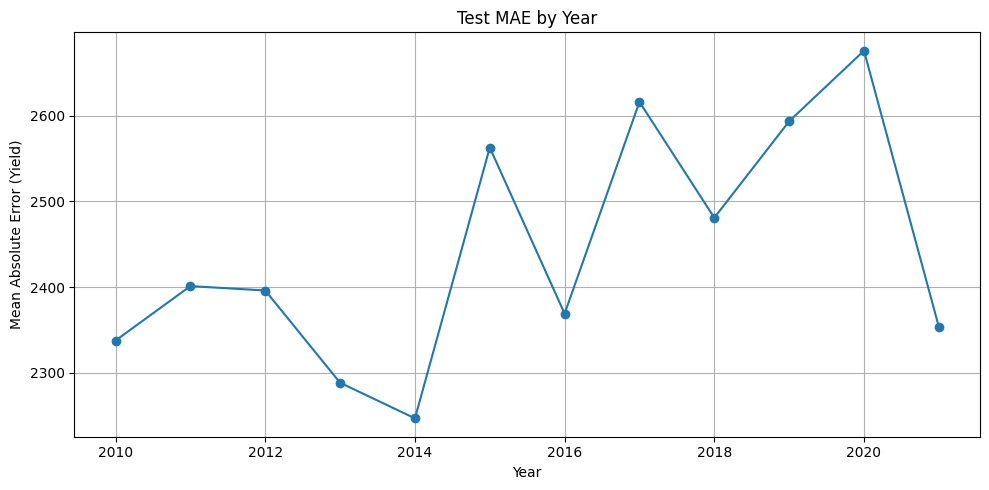

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(year_mae['year_raw'], year_mae['mae'], marker='o', linestyle='-')
plt.title("Test MAE by Year")
plt.xlabel("Year")
plt.ylabel("Mean Absolute Error (Yield)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
year_counts = test_df['year_raw'].value_counts().sort_index()
year_mae['count'] = year_counts.values
print(year_mae)

    year_raw          mae  count
0       2010  2337.601562   1078
1       2011  2401.142578   1109
2       2012  2395.997070   1049
3       2013  2288.274658   1039
4       2014  2246.706787   1062
5       2015  2562.978760   1013
6       2016  2368.954590   1033
7       2017  2616.259277    999
8       2018  2480.960449   1073
9       2019  2593.640625   1022
10      2020  2676.030518   1012
11      2021  2353.633545   1011
